## 集成学习和随机森林方法

### 集成

之前的几个实验中，介绍了不同的分类算法，以及验证、评估模型的技术。现在，假设已经为某一特定问题选中了最佳的模型，想进一步提升其准确率，就需要应用一些更高级的机器学习技术：集成（Ensemble）。集成是使用一系列学习器进行学习，并使用某种规则把各个学习结果进行整合从而获得比单个学习器更好的学习效果的一种机器学习方法。在集成中，最终的整体输出比任何单个部分的表现更重要。

某种意义上，孔多塞陪审团定理形象的描述了上面提到的集成概念。该定理的内容为：如果评审团的每个成员做出独立判断，并且每个陪审员做出正确决策的概率高于 0.5，那么整个评审团做出正确的总体决策的概率随着陪审员数量的增加而增加，并趋向于一。另一方面，如果每个陪审员判断正确的概率小于 0.5，那么整个陪审团做出正确的总体决策的概率随着陪审员数量的增加而减少，并趋向于零。

该定理的公式为：

$$  \mu = \sum_{i=m}^{N}{N\choose i}p^i(1-p)^{N-i} $$

其中，

- $N$ 为陪审员总数。
- $m$ 是构成多数的最小值，即 $m=\operatorname{floor}(N / 2)+1$。
- $ {N \choose i}$ 是组合数。
- $ p$ 为评审员做出正确决策的概率。
- $ \mu$ 是整个评审团做出正确决策的概率。

由上式可知，若 $ p > 0.5$，则 $ \mu > p$。此外，若  $ N \rightarrow \infty $，则 $ \mu \rightarrow 1$。

让我们看看另一个集成的例子：群体的智慧。1906 年，Francis Galton 访问了普利茅斯的一个农村集市，在那里他看到一个比赛。800 个参与者尝试估计一头屠宰的牛的重量。所有参与者的预测的平均值为 1197 磅，与牛的真实重量 1198 磅十分接近。

机器学习领域采用类似的思路以降低误差。

### Bootstrapping

Leo Breiman 于 1994 年提出的 Bagging（又称 Bootstrap Aggregation，引导聚集）是最基本的集成技术之一。Bagging 基于统计学中的 Bootstraping（自助法），该方法令复杂模型的统计评估变得更加可行。

Bootstrap 方法的流程如下：假设有尺寸为 N 的样本 X，从该样本中有放回地随机抽取 N 个样本，以创建一个新样本。换句话说，从尺寸为 N 的原样本中随机选择一个元素，并重复此过程 N 次。选中所有元素的可能性是一样的，因此每个元素被抽中的概率均为 $ \frac{1}{N}$。

假设用 Bootstrap 方法从一个袋子中抽球，每次抽一个。在每一步中，将选中的球放回袋子，这样下一次抽取是等概率的，即，从同样数量的 N 个球中抽取。注意，因为我们把球放回了，新样本中可能有重复的球。把这个新样本称为 $ X_1$。重复这一过程 M 次，创建 M 个 Bootstrap 样本 $ X_1, \dots, X_M$。最后，我们的样本数量就从原先的 1 个扩充到了 M 个，就有充足的样本来计算原始分布的多种统计数据。

看一个例子，这个例子使用之前的 telecom_churn 数据集。我们曾讨论过这一数据集的特征重要性，其中最重要的特征之一是呼叫客服次数（Customer service calls）。可视化「呼叫客服次数」这一特征，看看其分布。

In [1]:
import warnings
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
%matplotlib inline
warnings.filterwarnings('ignore')

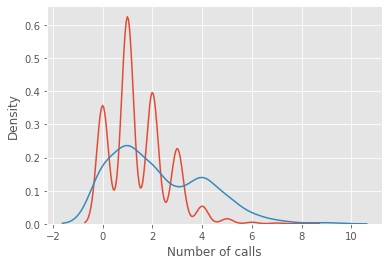

In [2]:
telecom_data = pd.read_csv('telecom_churn.csv')

fig = sns.kdeplot(telecom_data[telecom_data['Churn']
                               == False]['Customer service calls'], label='Loyal')
fig = sns.kdeplot(telecom_data[telecom_data['Churn']
                               == True]['Customer service calls'], label='Churn')
fig.set(xlabel='Number of calls', ylabel='Density')
plt.show()

上图表明，相比那些逐渐离网的客户，忠实客户呼叫客服的次数更少。估计每组客户的平均呼叫客服数可能很有用，但由于该数据集很小，如果直接计算原样本的均值，得到的估计可能较差。因此可以应用 Bootstrap 方法，基于原样本生成 1000 个新 Bootstrap 样本，然后计算均值的区间估计。

定义 `get_bootstrap_samples()` 函数产生 Bootstrap 样本，定义 `stat_intervals()` 函数产生一个区间估计。

In [3]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    boundaries = np.percentile(
        stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

分割数据集，分组为忠实客户和离网客户。

In [4]:
loyal_calls = telecom_data.loc[telecom_data['Churn'] == False,
                               'Customer service calls'].values
churn_calls = telecom_data.loc[telecom_data['Churn'] == True,
                               'Customer service calls'].values

固定随机数种子，以得到可重现的结果。

In [5]:
np.random.seed(0)

使用 Bootstrap 生成样本，计算各自的均值。

In [6]:
loyal_mean_scores = [np.mean(sample)
                     for sample in get_bootstrap_samples(loyal_calls, 1000)]
churn_mean_scores = [np.mean(sample)
                     for sample in get_bootstrap_samples(churn_calls, 1000)]

打印区间估计值，使用 `stat_intervals()` 函数将区间定义为 95%。

In [7]:
print("Service calls from loyal: mean interval",
      stat_intervals(loyal_mean_scores, 0.05))
print("Service calls from churn: mean interval",
      stat_intervals(churn_mean_scores, 0.05))

Service calls from loyal: mean interval [1.4077193  1.49473684]
Service calls from churn: mean interval [2.0621118  2.39761905]


上述结果表明，有 95% 的概率，忠实客户平均呼叫客服的次数在 1.4 到 1.49 之间，而离网客户平均呼叫客服的次数在 2.06 到 2.40 之间。另外，可以注意到忠实客户的区间更窄，这是合理的，因为相比多次呼叫客服的离网客户，忠实客户呼叫客服的次数更少（0、1、2 次）。

### Bagging

理解了 Bootstrap 概念之后，接下来介绍 Bagging。

假设我们有一个训练集 X。我们使用 Bootstrap 生成样本 $ X_1, \dots, X_M$。现在，我们在每个 Bootstrap 样本上分别训练分类器 $ a_i(x)$，最终的分类器将对所有这些单独的分类器的输出取均值。在分类情形下，这种技术即投票（voting）：

$$ a(x) = \frac{1}{M}\sum_{i = 1}^M a_i(x).$$

在回归问题中，通过对回归结果取均值，Bagging 将均方误差降至 $\frac{1}{M}$（M 为回归器数量）。

回顾一下上一课的内容，模型的预测误差由三部分构成：

$$ \mathrm{Bias}\left(\hat{f}\right)^2 + \mathrm{Var}\left(\hat{f}\right) + \sigma^2$$

Bagging 通过在不同数据集上训练模型的方式来降低分类器的方差。换句话说，Bagging 可以预防过拟合。由于来自不同训练数据集上的模型各不相同，它们的误差在投票过程中会相互抵消，所以 Bagging 是有效的。此外，某些 Bootstrap 训练样本很可能会忽略异常值。

让我们看下 Bagging 的实际效果，并与决策树比较下，如下图所示：

决策树的误差：

$$0.0255 (\mathrm{Err}) = 0.0003 (\mathrm{Bias}^2)  + 0.0152 (\mathrm{Var}) + 0.0098 (\sigma^2) $$

Bagging 的误差：

$$  0.0196 \, (\mathrm{Err}) = 0.0004 \, (\mathrm{Bias}^2)  + 0.0092 \, (\mathrm{Var}) + 0.0098 \, (\sigma^2) $$  

从上图可以看到，相比决策树，Bagging 误差中的方差值显著降低了。

上图的例子不太可能在实际工作中出现，因为它做了一个强假定：单独误差是不相关的。对现实世界的应用而言，这个强假定太过乐观。当这个假定不成立时，误差的下降就不会那么显著。在后续实验中，我们将讨论一些更复杂的集成方法，能够对现实世界的问题做出更精确的预测。

### 随机森林

在 Bagging 中，主要使用的基础分类器为决策树，因为决策树相当复杂，并能在任何样本上达到零分类误差。随机子空间方法可以降低树的相关性，从而避免过拟合。基于 Bagging，基础算法会在不同的原始特征集的随机子集上训练。

以下算法使用随机子空间方法构建集成模型：

- 设样本数等于 n，特征维度数等于 d。
- 选择模型的数目 M。
- 对于每个模型 m，选择特征数 dm<d。所有模型使用相同的 dm 值。
- 对每个模型 m，通过在整个 d 特征集合上随机选择 dm 个特征创建一个训练集。
- 训练每个模型。
- 通过组合 M 个模型的结果，将生成的整体模型应用于新数据中，应用时可以基于多数投票算法（majority voting）或后验概率聚合（aggregation of the posterior probabilities）。

#### 随机森林的算法

构建 N 棵树的随机森林算法如下：

- 对每个 $ k = 1, \dots, N$，生成 Bootstrap 样本 $ X_k$。
- 在样本 $ X_k$ 上创建一棵决策树 $ b_k$：
  - 根据给定的标准选择最佳的特征维度。根据该特征分割样本以创建树的新层。重复这一流程，直到样本用尽。
  - 创建树，直到任何叶节点包含的实例不超过 $ n_\text{min}$ 个，或者达到特定深度。
  - 每次分割，首先从 $d$ 个原始特征中随机选择 $m$ 个特征，接着只在该子集上搜索最佳分割。

最终分类器定义为：

$$ a(x) = \frac{1}{N}\sum_{k = 1}^N b_k(x)$$

分类问题使用多数投票算法，回归问题使用均值。在分类问题中，建议设定 $ m = \sqrt{d}$，取 $ n_\text{min} = 1$。回归问题中，一般取 $ m = \frac{d}{3}$，$ n_\text{min} = 5$。

可以将随机森林看成 Bagging 决策树的一个改动版本，因为随机森林在每个 Bagging 决策树的分割处选择了一个随机特征子空间。

#### 随机森林与 Bagging 和决策树的比较

导入所需包，配置环境：

In [8]:
from __future__ import division, print_function
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import seaborn as sns
from matplotlib import pyplot as plt

# Disable warnings in Anaconda
import warnings
import numpy as np
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6


n_train = 150
n_test = 1000
noise = 0.1

生成数据。

In [9]:
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y


X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

使用单棵决策树回归。

Text(0.5, 1.0, 'Decision tree, MSE = 20.09')

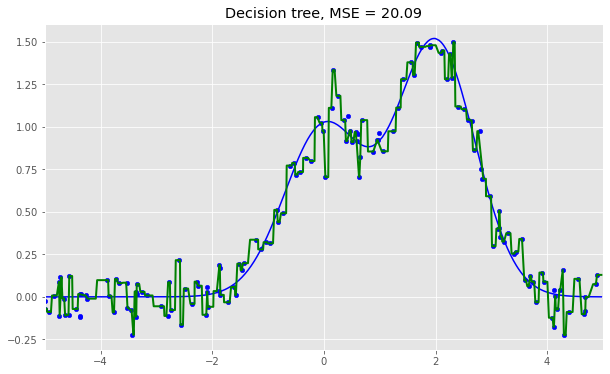

In [10]:
dtree = DecisionTreeRegressor().fit(X_train, y_train)
d_predict = dtree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, d_predict, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree, MSE = %.2f"
          % np.sum((y_test - d_predict) ** 2))

使用 Bagging 决策树回归。

Text(0.5, 1.0, 'Bagging for decision trees, MSE = 15.12')

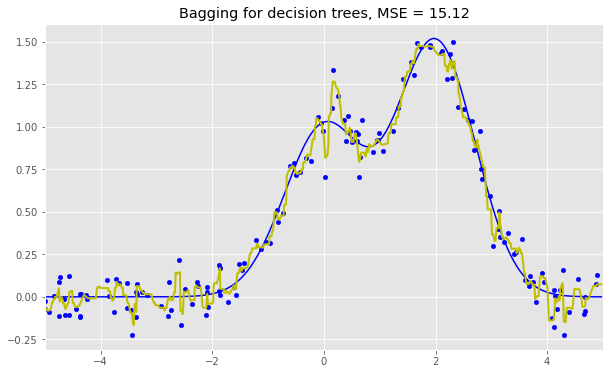

In [11]:
bdt = BaggingRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
bdt_predict = bdt.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, bdt_predict, "y", lw=2)
plt.xlim([-5, 5])
plt.title("Bagging for decision trees, MSE = %.2f" %
          np.sum((y_test - bdt_predict) ** 2))

使用随机森林。

Text(0.5, 1.0, 'Random forest, MSE = 15.07')

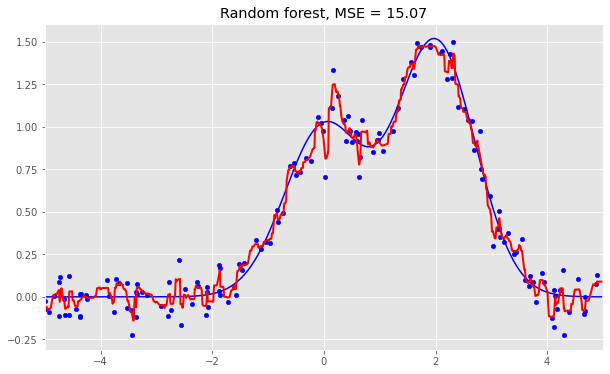

In [12]:
rf = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
rf_predict = rf.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, rf_predict, "r", lw=2)
plt.xlim([-5, 5])
plt.title("Random forest, MSE = %.2f" % np.sum((y_test - rf_predict) ** 2))

从上面 3 张图像和 MSE 值可以看到，10 树随机森林比单棵决策树和 10 树 Bagging 的表现要好，当然随机森林在这个例子上不稳定，多次运行结果表明随机森林和 Bagging 决策树互有胜负。随机森林和 Bagging 的主要差别在于，前者分割的最佳特征是从一个随机特征子空间中选取的，而后者在分割时将考虑所有特征。

接下来，我们将查看随机森林和 Bagging 在分类问题上的表现。

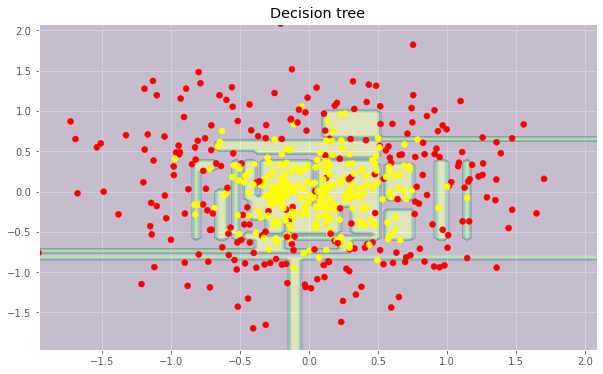

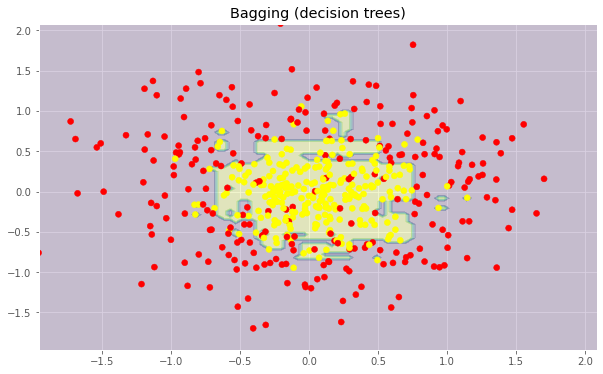

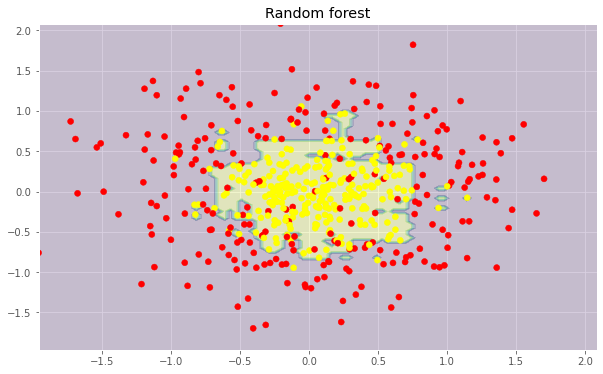

In [13]:
np.random.seed(42)
X, y = make_circles(n_samples=500, factor=0.1, noise=0.35, random_state=42)
X_train_circles, X_test_circles, y_train_circles, y_test_circles = train_test_split(
    X, y, test_size=0.2)

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
plt.title("Decision tree")
plt.show()

b_dtree = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=300, random_state=42)
b_dtree.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = b_dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
plt.title("Bagging (decision trees)")
plt.show()

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
plt.title("Random forest")
plt.show()

上图显示了决策树形成的边界凹凸不平，有大量锐角，这暗示出现过拟合现象。相反，随机森林和 Bagging 的边界相当平滑，没有明显的过拟合的迹象。

现在，看看哪些参数有利于提高随机森林模型的准确率。

#### 随机森林的参数

scikit-learn 库提供了 `BaggingRegressor` 和 `BaggingClassifier` 类，其中在创建新模型时需要注意的一些参数如下：

- n_estimators 是随机森林中树的数量；
- criterion 是衡量分割质量的函数；
- max_features 是查找最佳分割时考虑的特征数；
- min_samples_leaf 是叶节点的最小样本数；
- max_depth 是树的最大深度。

#### 随机森林在现实问题中的应用

使用之前运营商的客户离网数据集作为例子。这是一个分类问题，使用准确率评估模型。

首先，创建一个简单的分类器作为基线。出于简单的目的，只使用数值特征构建分类器。

In [14]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

加载数据集。

In [15]:
df = pd.read_csv("telecom_churn.csv")

选择数值特性。

In [16]:
cols = []
for i in df.columns:
    if (df[i].dtype == "float64") or (df[i].dtype == 'int64'):
        cols.append(i)

将数据集分离为输入变量和目标变量。

In [17]:
X, y = df[cols].copy(), np.asarray(df["Churn"], dtype='int8')

为验证过程进行分层分割。

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

基于默认参数初始化分类器。

In [19]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

在训练集上进行训练。

In [20]:
results = cross_val_score(rfc, X, y, cv=skf)

在测试集上评估准确率。

In [21]:
print("CV accuracy score: {:.2f}%".format(results.mean()*100))

CV accuracy score: 92.50%


得到了 91.48% 的准确率作为基线，现在，尝试改进结果，同时查看一下基本参数变化时的学习曲线。首先，从改进树的数量开始，初始化 K 折交叉验证。

In [22]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

创建列表储存训练集和测试集上的准确率。

In [23]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []

进行网格搜索。下方列表中候选数值较多，会增加线上环境执行时间，可以自行减少数量以加快运行。

In [24]:
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

在训练集上训练模型。

In [25]:
for ntrees in trees_grid:
    rfc = RandomForestClassifier(
        n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

打印结果。

In [26]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100,
                                                            trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.50% with 100 trees


接下来，绘制相应的学习曲线。

Text(0.5, 0, 'N_estimators')

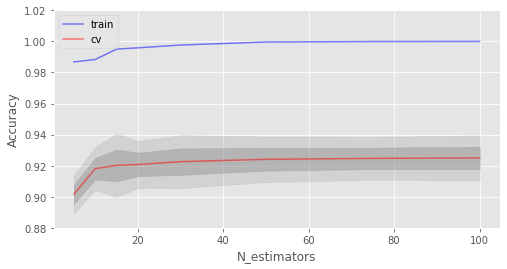

In [27]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1),
        alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1),
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1),
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88, 1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

上图表明，当树的数量增加到一定值时，测试集上的准确率不再提升，同时训练集上的准确率达到了 100%，这意味着出现过拟合。

为了避免过拟合，需要给模型加上正则化参数。下面将树的数目固定为 100，然后看看不同的 max_depth 效果如何，首先创建列表以保存训练和测试集上的准确率。

In [28]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

在训练集上训练模型。

In [29]:
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(
        n_estimators=100, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

打印结果。

Best accuracy on CV is 92.44% with 24 max_depth


Text(0.5, 0, 'Max_depth')

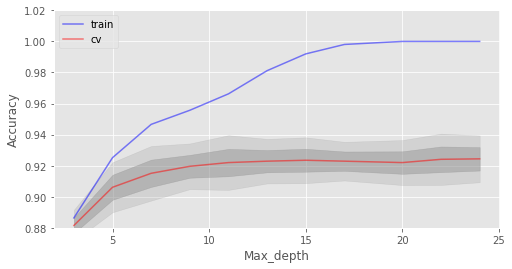

In [30]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100,
                                                                max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1),
        alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1),
        alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1),
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1),
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88, 1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth")

max_depth 在模型中起到了正则化的作用，过拟合现象有所缓解，模型准确率提高了一些。

另一个值得调整的重要参数是 min_samples_leaf，它也能起到正则化作用。首先，创建列表以保存训练和测试集上的准确率。

In [31]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

在训练集上训练模型。

In [32]:
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

打印结果。

Best accuracy on CV is 92.50% with 1 min_samples_leaf


Text(0.5, 0, 'Min_samples_leaf')

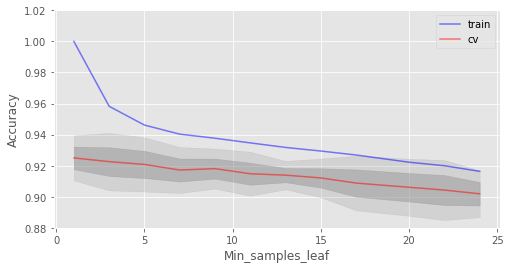

In [33]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100,
                                                                       min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(
    axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(
    axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1),
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1),
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88, 1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf")

在这一情形下，验证集上的准确率没有提高，但当验证集的准确率保持 92%以上时，过拟合的情况降低了 2%。

下面考虑 max_features 这一参数。在分类问题中，默认特征为「所有特征数的平方根」。首先，检查在这个例子中选择 4 个特征是否是最佳的，创建列表以保存训练和测试集的准确率。

In [34]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

在训练集上训练模型。

In [35]:
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

打印结果。

Best accuracy on CV is 92.50% with 4 max_features


Text(0.5, 0, 'Max_features')

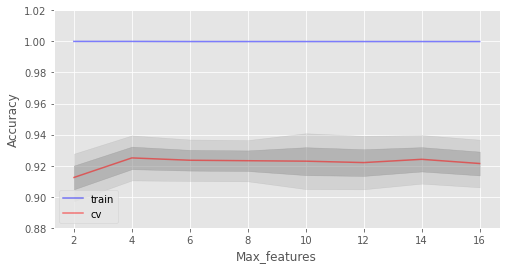

In [36]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100,
                                                                   max_features_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1),
        alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1),
        alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1),
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1),
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88, 1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features")

上图表明，在这个例子中，max_features=12 时模型表现最好。

我们已经看到学习曲线如何随着基本参数的变化而变化。现在，直接使用 `GridSearch()` 来查找最佳参数。首先，初始化参数集以进行穷举搜索和拟合。

In [37]:
# 原实验搜索参数
# parameters = {'max_features': [4, 7, 10, 13], 'min_samples_leaf': [
#     1, 3, 5, 7], 'max_depth': [5, 10, 15, 20]}
# 为加速线上环境执行，优化搜索参数
parameters = {'max_features': [10, 13], 'min_samples_leaf': [1, 3], 'max_depth': [5, 10]}
rfc = RandomForestClassifier(n_estimators=100, random_state=42,
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'max_features': [10, 13],
                         'min_samples_leaf': [1, 3]},
             verbose=1)

打印结果。

In [38]:
gcv.best_estimator_, gcv.best_score_

(RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=3,
                        n_jobs=-1, oob_score=True, random_state=42),
 0.9246971109040075)